In [1]:
import numpy as np
import PIL
import json
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

C:\Users\ehtes\AppData\Roaming\Python\Python310\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
with open("params.json", 'r') as params_file:
    params = json.load(params_file)

In [3]:
train_data_dir = params["dir"]["train_dataset"]
test_data_dir = params["dir"]["test_dataset"]
val_data_dir = params["dir"]["val_dataset"]
img_height = params["img_params"]["img_height"]
img_width = params["img_params"]["img_width"]
batch_size = params["model_params"]["batch_size"]
epochs = params["model_params"]["epochs"]

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3115 files belonging to 36 classes.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  val_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 351 files belonging to 36 classes.


In [6]:
class_name = train_ds.class_names
class_name

['apple',
 'banana',
 'beetroot',
 'bell pepper',
 'cabbage',
 'capsicum',
 'carrot',
 'cauliflower',
 'chilli pepper',
 'corn',
 'cucumber',
 'eggplant',
 'garlic',
 'ginger',
 'grapes',
 'jalepeno',
 'kiwi',
 'lemon',
 'lettuce',
 'mango',
 'onion',
 'orange',
 'paprika',
 'pear',
 'peas',
 'pineapple',
 'pomegranate',
 'potato',
 'raddish',
 'soy beans',
 'spinach',
 'sweetcorn',
 'sweetpotato',
 'tomato',
 'turnip',
 'watermelon']

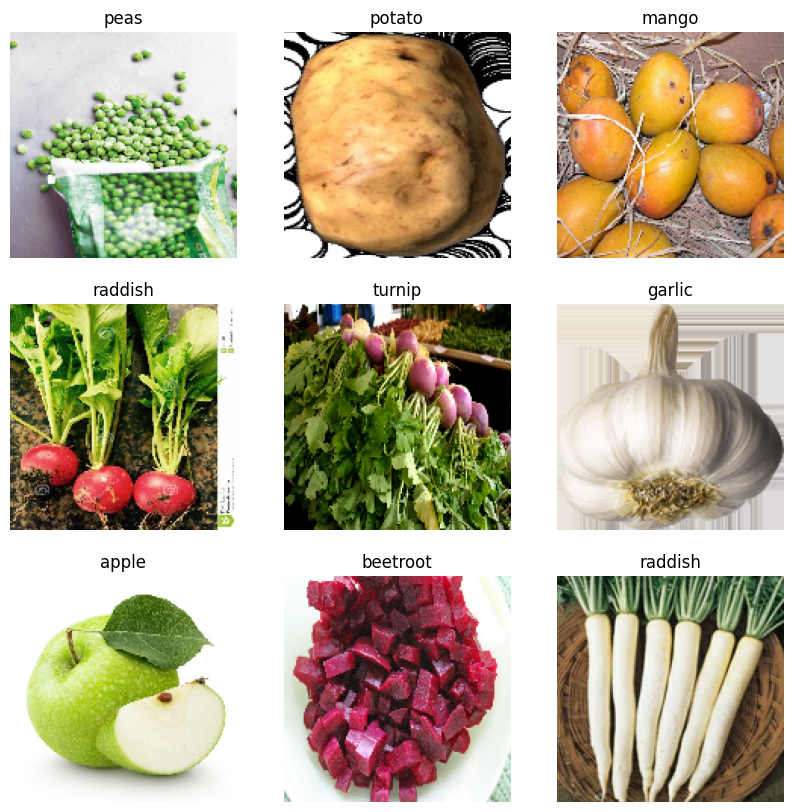

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_name[labels[i]])
    plt.axis("off")

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [10]:
num_classes = len(class_name)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="output")
])

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                  

In [13]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
98/98 [==============================] - 66s 384ms/step - loss: 3.3791 - accuracy: 0.0597 - val_loss: 2.9858 - val_accuracy: 0.1225
Epoch 2/50
98/98 [==============================] - 34s 345ms/step - loss: 2.7803 - accuracy: 0.1859 - val_loss: 2.3029 - val_accuracy: 0.2906
Epoch 3/50
98/98 [==============================] - 31s 314ms/step - loss: 2.4074 - accuracy: 0.2677 - val_loss: 1.9515 - val_accuracy: 0.3932
Epoch 4/50
98/98 [==============================] - 32s 324ms/step - loss: 2.1774 - accuracy: 0.3358 - val_loss: 1.7404 - val_accuracy: 0.4274
Epoch 5/50
98/98 [==============================] - 32s 330ms/step - loss: 2.0333 - accuracy: 0.3856 - val_loss: 1.6463 - val_accuracy: 0.4501
Epoch 6/50
98/98 [==============================] - 31s 323ms/step - loss: 1.8909 - accuracy: 0.4045 - val_loss: 1.6643 - val_accuracy: 0.4473
Epoch 7/50
98/98 [==============================] - 33s 333ms/step - loss: 1.7754 - accuracy: 0.4600 - val_loss: 1.6388 - val_accuracy: 0.4786

In [14]:
model.save("food_recognition.h5")

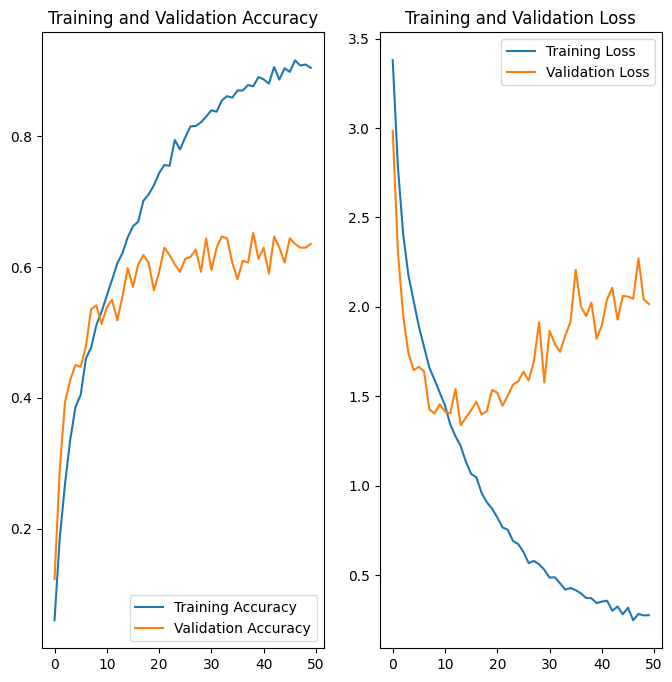

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()